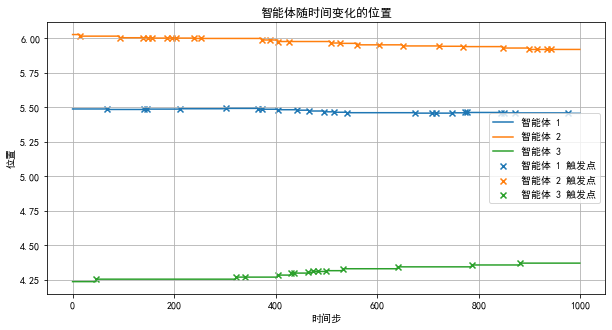

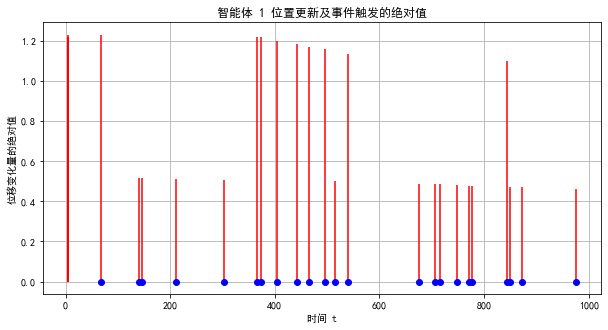

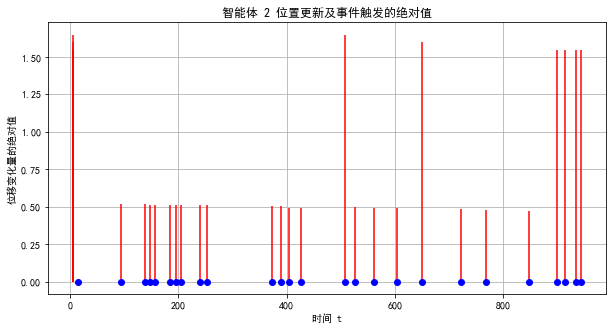

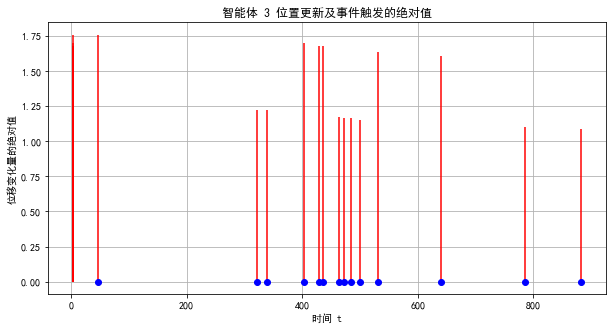

In [25]:
import numpy as np
import matplotlib.pyplot as plt


class Agent:
    def __init__(self, initial_position, index):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.sigma = 0.5  # 触发函数参数
        #self.alpha = 0.5
        self.alpha = np.random.uniform(0, 1 / max(1, len(self.neighbors)))  # 另一个触发函数参数
        self.trigger_points = []
        self.trigger_points2 = []  # 用于记录事件触发时的位置
        self.delta_positions = []

    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def get_position(self):
        return self.position
    
    def broadcast_position(self):
        # 广播当前位置给所有邻居
        for neighbor in self.neighbors:
            neighbor.last_broadcast_position = self.position

    def update_position(self, dt):
        # 使用从邻居处接收到的最新广播状态
        broadcast_positions = [neighbor.last_broadcast_position for neighbor in self.neighbors]
        average_position = np.mean(broadcast_positions) if broadcast_positions else self.position
        position_error = average_position - self.position  # 计算误差

        
        e_i = self.last_broadcast_position - self.position
        #self.broadcast_position()

        z_bar_squared = sum(self.is_neighbor(neighbor) * (neighbor.get_position() - self.position) for neighbor in self.neighbors)

        trigger_condition = e_i ** 2 - self.sigma * self.alpha * (1 - self.alpha * len(self.neighbors)) * z_bar_squared  / len(self.neighbors)


        a = np.random.uniform(-50, 1)
        # 如果事件触发函数大于等于0，则更新位置并广播新位置
        if trigger_condition >= 0:
            #print(e_i ** 2)
            #print(self.sigma * self.alpha * (1 - self.alpha * len(self.neighbors)) * z_bar_squared ** 2 / len(self.neighbors))
            #print(z_bar_squared ** 2)
            #print(trigger_condition)
            #print("1")
            #print(self.alpha)
            #print()
            
            self.position += position_error * dt
            self.broadcast_position()  # 广播更新后的位置

            self.delta_positions.append(self.last_broadcast_position - self.position)
            self.trigger_points2.append(t * dt)
            self.trigger_points.append((t, self.position))
        #else:
            #print("nonononononono")

# 初始化参数和智能体
num_agents = 3
num_iterations = 1000
dt = 0.01
np.random.seed(0)
agents = [Agent(np.random.rand() * 10, i) for i in range(num_agents)]

# 定义邻居关系
agents[0].add_neighbor(agents[1])
agents[0].add_neighbor(agents[2])
#agents[0].add_neighbor(agents[3])
#agents[2].add_neighbor(agents[4])
#agents[1].add_neighbor(agents[3])
agents[2].add_neighbor(agents[1])


# 运行模拟
positions = np.zeros((num_iterations, num_agents))
for t in range(num_iterations):
    for agent in agents:
        agent.update_position(dt)
        positions[t, agent.index] = agent.position

# 绘制结果图
plt.figure(figsize=(10, 5))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'智能体 {i+1}')
    # 绘制事件触发点
    if agent.trigger_points:
        trigger_times, trigger_positions = zip(*agent.trigger_points)
        plt.scatter(trigger_times, trigger_positions, marker='x', label=f'智能体 {i + 1} 触发点')

plt.xlabel('时间步')
plt.ylabel('位置')
plt.title('智能体随时间变化的位置')
plt.legend()
plt.grid(True)



#plt.show()


for index, agent in enumerate(agents):
    plt.figure(figsize=(10, 5))
    
    # Iterate over the agent's recorded trigger points and corresponding position changes
    for trigger_time, delta_position in zip(agent.trigger_points, agent.delta_positions):
        # Only if there is a change, i.e., delta_position is not zero
        if delta_position != 0:
            # Compute the absolute value of the position change
            absolute_delta = abs(delta_position)
            # Plot a vertical line from 0 to the absolute change value at the trigger time
            plt.vlines(trigger_time, 0, absolute_delta, colors='r')
            # Plot a blue dot at the bottom (x-axis) of the line
            plt.plot(trigger_time[0], 0, 'bo')  # Blue dot at the x-axis

    plt.xlabel('时间 t')
    plt.ylabel('位移变化量的绝对值')
    plt.title(f'智能体 {index + 1} 位置更新及事件触发的绝对值')
    plt.grid(True)

    # 解决中文显示问题
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号 '-' 显示为方块的问题

    plt.show()